# CPTAC3 and DKFZ Validation for TCGA data trained Models

*CPTAC3&DKFZ.ipynb* notebook is offering detailed step-by-step instructions on how to validate CPTAC-3 LUAD, LUSC and DKFZ PRAD dataset through contrastive learning model trained by TCGA dataset.

## Prepare Dataset

The notebook [*CPTAC3_Preprocessing.ipynb*](https://github.com/CaixdLab/CL4CaPro/blob/main/CPTAC3_Preprocessing.ipynb), [*GenerateCPTAC3_Dataset.ipynb*](https://github.com/CaixdLab/CL4CaPro/blob/main/GenerateCPTAC3_Dataset.ipynb), [*DKFZ_Preprocessing.ipynb*](https://github.com/CaixdLab/CL4CaPro/blob/main/DKFZ_Preprocessing.ipynb), and [*GenerateDKFZ_Dataset.ipynb*](https://github.com/CaixdLab/CL4CaPro/blob/main/GenerateDKFZ_Dataset.ipynb) can be found in our GitHub repository. It is designed to create the necessary CPTAC3 and DKFZ validation datasets from the original data files. Additionally, we have made a preprocessed mapped dataset available in the repository for direct download, allowing users to proceed directly to the dataset setup section.

## Setup Dataset

Pick Cancer and Task and choose corresponding prepared mapped dataset (Download in CPTAC-3&DKFZ folder)
1. CancerRNA_CPTAC3_LUAD_WholeTimeSeq_3.txt
2. CancerRNA_CPTAC3_LUSC_WholeTimeSeq_3.txt
3. CancerRNA_DKFZ_PRAD_WholeTimeSeq_3.txt
4. CancerRNA_CPTAC3_LUAD_Risk_2.txt
5. CancerRNA_CPTAC3_LUSC_Risk_2.txt
6. CancerRNA_DKFZ_PRAD_Risk_2.txt

Make sure them in the CPTAC3&DKFZ folder.

In [ ]:
Task = 'Classifier' # Other options Cox
Cancer = 'LUAD' # Other options LUSC, PRAD

Get Contrastive Learning Model path

In [ ]:
import os

def find_clcp_folder_name(directory):
    for folder_name in os.listdir(directory):
        if folder_name.startswith('CLCP'):
            return folder_name
    return 'No CLCP folder found.'

if Task == 'Classifier':
    task_get = 'Risk' # Classifier
else:
    task_get = 'WholeTimeSeq' # Cox

# Assuming the directory to search is the current working directory
if task_get == 'Risk':
    directory_to_search = './CL4CaPro_Models/Classifier Models/{}'.format(Cancer)
else:
    directory_to_search = './CL4CaPro_Models/Cox Models/{}'.format(Cancer)
clcp_folder_name = find_clcp_folder_name(directory_to_search)
model_pth = os.path.join(directory_to_search, clcp_folder_name)

Generate Contrastive Learning Model features

In [ ]:
para = clcp_folder_name.split('_')
input_dim = para[1]
model_n_hidden_1 = para[2]
model_out_dim = para[3]
feat_dim = para[5]
batch_size = para[-3]
l2_rate = para[9]
seed = para[13]
round = para[11]
device = 0
lr = para[7]

In [ ]:
! python GenerateFeatures_CPTAC3.py --layer_name feat --model_in_dim {input_dim} --dim_1_list {model_n_hidden_1} \
                                    --dim_2_list {model_out_dim} --dim_3_list {feat_dim} --batch_size {batch_size} \
                                    --l2_rate {l2_rate} --seed {seed} --round {round} --gpu_device {device} \
                                    --learning_rate_list {lr} --task {task_get} --model_save_path {model_pth} \
                                    --cancer_group {cancer}

## Predict Results

### XGB Classifier
Predict Results and Calculate AUC_ROC

In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, auc, roc_curve, roc_auc_score

# Initialize a model instance
loaded_classifier_model = XGBClassifier()

# Load the model from the file
loaded_classifier_model.load_model('./CL4CaPro_Models/Classifier Models/{}/classifier_model.json'.format(Cancer))

predict_input_df = pd.read_csv('Features/CPTAC3DKFZFeature_{}.txt'.format(Cancer))
X = predict_input_df.iloc[:, 6:]
y_test = predict_input_df['predicted_label']

predictions = loaded_classifier_model.predict(X)

prob_predictions = loaded_classifier_model.predict_proba(X)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, prob_predictions)
auc_roc = roc_auc_score(y_test, prob_predictions)
print(auc_roc)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show

f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

### Cox-XGB
Predict Results and Calculate C-index and IBS

In [ ]:
import xgboost as xgb
from xgbse.converters import convert_data_to_xgb_format
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from Cal_IBS import BreslowEstimator
import numpy as np

# Initialize a model instance
loaded_cox_model = xgb.Booster()

# Load the model from the file
loaded_cox_model.load_model('.'
                            '{}/coxxgb_model.json'.format(Cancer))

predict_input_df = pd.read_csv('Features/CPTAC3DKFZFeature_{}.txt'.format(Cancer))
X = predict_input_df.iloc[:, 6:]
y_test = predict_input_df[['PFItime', 'PFI']]

train_input_df = pd.read_csv('./CL4CaPro_Models/Cox Models/{}/model_CLCP_*.txt'.format(Cancer))
x_train = train_input_df.iloc[:, 6:]
y = train_input_df[['PFItime', 'PFI']]

# Calculate the time points
combined_time_test_list = list(zip(y_test['Status'], y_test['Survival_in_days']))
combined_time_train_list = list(zip(y['Status'], y['Survival_in_days']))
sorted_combined_time_test_list = sorted(combined_time_test_list, key=lambda x: x[1])
sorted_combined_time_train_list = sorted(combined_time_train_list, key=lambda x: x[1])
sorted_status_test, sorted_time_test = zip(*sorted_combined_time_test_list)
sorted_status_train, sorted_time_train = zip(*sorted_combined_time_train_list)

last_true_index = -1
num_thre = 20
for index, status in reversed(list(enumerate(sorted_status_train))):
    if status and index <= len(sorted_status_train) - (num_thre + 1):
        last_true_index = index
        break
sorted_time_train_end = sorted_time_train[last_true_index]

last_true_index = -1
num_thre = 20
for index, status in reversed(list(enumerate(sorted_status_test))):
    if status and index <= len(sorted_status_test) - (num_thre + 1):
        last_true_index = index
        break
sorted_time_test_end = sorted_time_train[last_true_index]

# sorted_time_test_end = sorted_time_test[int(0.8 * len(sorted_time_test))]
sorted_time_test_start = sorted_time_test[int(0 * len(sorted_time_test))]
# sorted_time_train_end = sorted_time_train[int(0.8 * len(sorted_time_train))]
sorted_time_train_start = sorted_time_train[int(0 * len(sorted_time_train))]
times = np.arange(max(sorted_time_test_start, sorted_time_train_start),
                  min(sorted_time_test_end, sorted_time_train_end))

dval = convert_data_to_xgb_format(X, y_test, 'survival:cox')
dtrain = convert_data_to_xgb_format(x_train, y, 'survival:cox')

predictions = loaded_cox_model.predict(X)

test_pred = loaded_cox_model.predict(dval)
train_pred = loaded_cox_model.predict(dtrain)

scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], predictions)
c_index = round(scores[0], 10)

baseline_model = BreslowEstimator().fit(train_pred, y['Status'], y['Survival_in_days'])
survs = baseline_model.get_survival_function(test_pred)
preds = np.asarray([[fn(t) for t in times] for fn in survs])
scores = integrated_brier_score(y, y_test, preds, times)
ibs = round(scores[0], 6)

print(predictions, c_index, ibs)

### Cox-EN
Predict Results and Calculate C-index and IBS

In [ ]:
from joblib import load
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from Cal_IBS import BreslowEstimator
import numpy as np

# Load the model from file
estimator_loaded = load('./CL4CaPro_Models/Cox Models/{}/coxen_model.joblib'.format(Cancer))

predict_input_df = pd.read_csv('Features/CPTAC3DKFZFeature_{}.txt'.format(Cancer))
X = predict_input_df.iloc[:, 6:]
y_test = predict_input_df[['PFItime', 'PFI']]

train_input_df = pd.read_csv('./CL4CaPro_Models/Cox Models/{}/model_CLCP_*.txt'.format(Cancer))
x_train = train_input_df.iloc[:, 6:]
y = train_input_df[['PFItime', 'PFI']]

# Calculate the time points
combined_time_test_list = list(zip(y_test['Status'], y_test['Survival_in_days']))
combined_time_train_list = list(zip(y['Status'], y['Survival_in_days']))
sorted_combined_time_test_list = sorted(combined_time_test_list, key=lambda x: x[1])
sorted_combined_time_train_list = sorted(combined_time_train_list, key=lambda x: x[1])
sorted_status_test, sorted_time_test = zip(*sorted_combined_time_test_list)
sorted_status_train, sorted_time_train = zip(*sorted_combined_time_train_list)

last_true_index = -1
num_thre = 20
for index, status in reversed(list(enumerate(sorted_status_train))):
    if status and index <= len(sorted_status_train) - (num_thre + 1):
        last_true_index = index
        break
sorted_time_train_end = sorted_time_train[last_true_index]

last_true_index = -1
num_thre = 20
for index, status in reversed(list(enumerate(sorted_status_test))):
    if status and index <= len(sorted_status_test) - (num_thre + 1):
        last_true_index = index
        break
sorted_time_test_end = sorted_time_train[last_true_index]

# sorted_time_test_end = sorted_time_test[int(0.8 * len(sorted_time_test))]
sorted_time_test_start = sorted_time_test[int(0 * len(sorted_time_test))]
# sorted_time_train_end = sorted_time_train[int(0.8 * len(sorted_time_train))]
sorted_time_train_start = sorted_time_train[int(0 * len(sorted_time_train))]
times = np.arange(max(sorted_time_test_start, sorted_time_train_start),
                  min(sorted_time_test_end, sorted_time_train_end))

# Now you can use estimator_loaded for predictions
test_pred = estimator_loaded.predict(X)

scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], estimator_loaded.predict(X))
c_index = round(scores[0], 6)

train_preds = estimator_loaded.predict(x_train)
baseline_model = BreslowEstimator().fit(train_preds, y['Status'], y['Survival_in_days'])
survs = baseline_model.get_survival_function(test_pred)
preds = np.asarray([[fn(t) for t in times] for fn in survs])
scores = integrated_brier_score(y, y_test, preds, times)
ibs = round(scores[0], 6)

print(predictions, c_index, ibs)

### Cox-nnet
Predict Results and Calculate C-index and IBS

In [ ]:
from cox_nnet import *
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from Cal_IBS import BreslowEstimator
import numpy as np

# Load the model from file
coxnnet_loaded = loadModel('./CL4CaPro_Models/Cox Models/{}/coxnn_model.pkl'.format(Cancer))

predict_input_df = pd.read_csv('Features/CPTAC3DKFZFeature_{}.txt'.format(Cancer))
X = predict_input_df.iloc[:, 6:]
y_test = predict_input_df[['PFItime', 'PFI']]

train_input_df = pd.read_csv('./CL4CaPro_Models/Cox Models/{}/model_CLCP_*.txt'.format(Cancer))
x_train = train_input_df.iloc[:, 6:]
y = train_input_df[['PFItime', 'PFI']]

# Calculate the time points
combined_time_test_list = list(zip(y_test['Status'], y_test['Survival_in_days']))
combined_time_train_list = list(zip(y['Status'], y['Survival_in_days']))
sorted_combined_time_test_list = sorted(combined_time_test_list, key=lambda x: x[1])
sorted_combined_time_train_list = sorted(combined_time_train_list, key=lambda x: x[1])
sorted_status_test, sorted_time_test = zip(*sorted_combined_time_test_list)
sorted_status_train, sorted_time_train = zip(*sorted_combined_time_train_list)

last_true_index = -1
num_thre = 20
for index, status in reversed(list(enumerate(sorted_status_train))):
    if status and index <= len(sorted_status_train) - (num_thre + 1):
        last_true_index = index
        break
sorted_time_train_end = sorted_time_train[last_true_index]

last_true_index = -1
num_thre = 20
for index, status in reversed(list(enumerate(sorted_status_test))):
    if status and index <= len(sorted_status_test) - (num_thre + 1):
        last_true_index = index
        break
sorted_time_test_end = sorted_time_train[last_true_index]

# sorted_time_test_end = sorted_time_test[int(0.8 * len(sorted_time_test))]
sorted_time_test_start = sorted_time_test[int(0 * len(sorted_time_test))]
# sorted_time_train_end = sorted_time_train[int(0.8 * len(sorted_time_train))]
sorted_time_train_start = sorted_time_train[int(0 * len(sorted_time_train))]
times = np.arange(max(sorted_time_test_start, sorted_time_train_start),
                  min(sorted_time_test_end, sorted_time_train_end))

test_pred = coxnnet_loaded.predictNewData(X)

scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], coxnnet_loaded.predictNewData(X))
c_index = round(scores[0], 6)

train_preds = coxnnet_loaded.predictNewData(x_train)
baseline_model = BreslowEstimator().fit(train_preds, y['Status'], y['Survival_in_days'])
survs = baseline_model.get_survival_function(test_pred)
preds = np.asarray([[fn(t) for t in times] for fn in survs])
scores = integrated_brier_score(y, y_test, preds, times)
ibs = round(scores[0], 6)

print(predictions, c_index, ibs)

## 40 Seed Validation Results
### Import libraries

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import auc
from scipy.stats import ranksums
plt.rcdefaults()

### CPTAC-3 LUAD non-CL XGBoost

LUAD


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

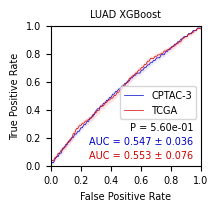

In [3]:
cancer_group_list = ["LUAD"]

method = "FZ" # Fill Zero

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_vali'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name and method in file_name:
            auc_get = float(file_name.split('_')[-4])
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='CPTAC-3')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='TCGA')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('False Positive Rate', fontsize=7)
    plt.ylabel('True Positive Rate', fontsize=7)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.title('{} XGBoost'.format(cancer_get), fontsize=7)


    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)

    plt.show()

### CPTAC-3 LUAD CL XGBoost

LUAD


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

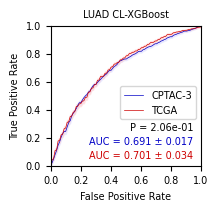

In [10]:
cancer_group_list = ["LUAD"]

method = "FZ"

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_vali_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name and method in file_name:
            auc_get = float(file_name.split('_')[-4])
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='CPTAC-3')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='TCGA')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('False Positive Rate', fontsize=7)
    plt.ylabel('True Positive Rate', fontsize=7)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.title('{} CL-XGBoost'.format(cancer_get), fontsize=7)

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)

    plt.show()

### CPTAC-3 LUSC non-CL XGBoost

LUSC


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

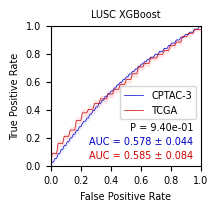

In [4]:
cancer_group_list = ["LUSC"]

method = "FZ"

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_vali'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name and method in file_name:
            auc_get = float(file_name.split('_')[-4])
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='CPTAC-3')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='TCGA')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('False Positive Rate', fontsize=7)
    plt.ylabel('True Positive Rate', fontsize=7)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.title('{} XGBoost'.format(cancer_get), fontsize=7)

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)

    plt.show()

### CPTAC-3 LUSC CL XGBoost

LUSC


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

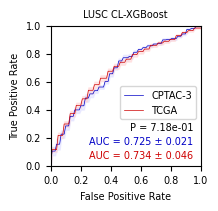

In [9]:
cancer_group_list = ["LUSC"]

method = "FZ"

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_vali_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name and method in file_name:
            auc_get = float(file_name.split('_')[-4])
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='CPTAC-3')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='TCGA')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('False Positive Rate', fontsize=7)
    plt.ylabel('True Positive Rate', fontsize=7)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.title('{} CL-XGBoost'.format(cancer_get), fontsize=7)

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)

    plt.show()

### DKFZ PRAD non-CL XGBoost

PRAD


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

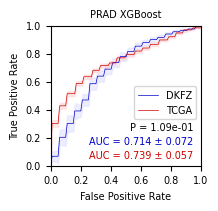

In [7]:
cancer_group_list = ["PRAD"]

method = "FZ"

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_vali'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name and method in file_name:
            auc_get = float(file_name.split('_')[-4])
            if auc_get > tw_1:
                file_path = os.path.join(extracted_folder_path, file_name)
                fpr, tpr = load_fpr_tpr(file_path)
                fpr_list.append(fpr)
                tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='DKFZ')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='TCGA')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('False Positive Rate', fontsize=7)
    plt.ylabel('True Positive Rate', fontsize=7)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.title('{} XGBoost'.format(cancer_get), fontsize=7)

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)

    plt.show()

### DKFZ PRAD CL XGBoost

PRAD


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

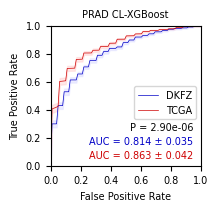

In [8]:
cancer_group_list = ["PRAD"]

method = "FZ"

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_vali_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name and method in file_name:
            auc_get = float(file_name.split('_')[-4])
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='DKFZ')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='TCGA')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('False Positive Rate', fontsize=7)
    plt.ylabel('True Positive Rate', fontsize=7)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.title('{} CL-XGBoost'.format(cancer_get), fontsize=7)

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)

    plt.show()